## RUL prediction using Long Short Term Memory (LSTM) network

In this notebook, we will use LSTM to predict RUL of NASA's turbofan engine dataset FD004. We will show the implementation without going into the theory of LSTM.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(2627)

In [2]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.6.0
Numpy version:  1.19.5
Pandas version:  1.3.3
Scikit-learn version:  1.0


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: No (Tree based methods don't require data scaling)

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate. 

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly. 

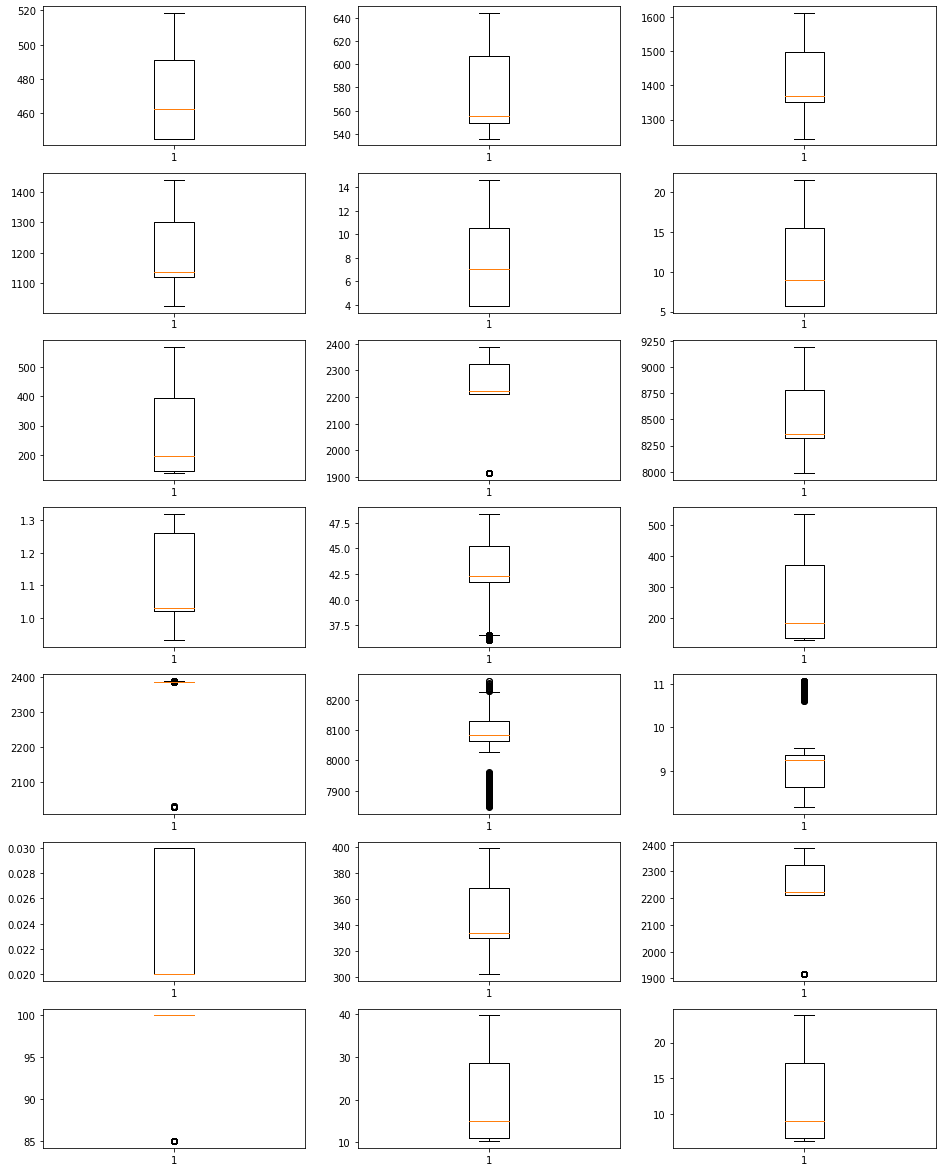

In [3]:
train_data = pd.read_csv("/home/biswajit/data/cmapss_data/train_FD004.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [4]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
        
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

We will modify the next functions a little bit to handle a special case. Later, for this dataset, we will be using window_size of 30. But upon some investigation, it can be found that there are a few test engines for which test data doesn't contain 30 rows. If test data for an engine doesn't contain 30 rows, how can we extract 30 rows from it? To circumvent this issue, we will append zeros to the end of that dataset. But while making predictions, we will ignore those appended zeros. This is called masking. The appended extra zeros are masked so that it doesn't influence our prediction. In Tensorflow, LSTM layers can take a mask argument to ignore specific input values. So we modify the function below to create a mask that is compatible with Tensorflow.

Similarly, to the decoder we pass only the last line of every window of test dataset. But if we have appended last few lines of data of an engine by zeros, taking its last row would mean taking all zeros. To overcome this problem, the function returns test_decoder_for_an_engine as another output.

In [6]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function returns last examples, number of last examples (a scaler), a mask, and test_decoder sequence as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :]                                                
    
    else:
        max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
        
        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask
        
        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask

There are two scaling strategies that we can employ. We can scale columnwise, ignoring individual engine based scaling. Or we can scale enginewise.

In [7]:
test_data = pd.read_csv("/home/biswajit/data/cmapss_data/test_FD004.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("/home/biswajit/data/cmapss_data/RUL_FD004.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 150         
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []
test_mask = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
# scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values


    # Prepare test data
    test_data_for_an_engine, num_windows, test_mask_for_an_engine = process_test_data(temp_test_data,
                                                                                      window_length = window_length,
                                                                                      shift = shift,
                                                                                      num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
    test_mask.append(test_mask_for_an_engine)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
test_mask = np.concatenate(test_mask)

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("Test mask shape: ", test_mask.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (54028, 30, 21)
Processed training ruls shape:  (54028,)
Processed test data shape:  (1196, 30, 21)
Test mask shape:  (1196, 30)
True RUL shape:  (248,)


Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [8]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

## Training and validation split
We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [9]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (43222, 30, 21)
Processed validation data shape:  (10806, 30, 21)
Processed train targets shape:  (43222,)
Processed validation targets shape:  (10806,)


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((processed_val_data, processed_val_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data, test_mask)).batch(128).prefetch(tf.data.AUTOTUNE)

2021-12-27 11:59:08.700880: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-27 11:59:09.229390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15405 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:61:00.0, compute capability: 6.0


In [11]:
## Create a custom model
class CreateModel(tf.keras.Model):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.lstm_layer_1 = layers.LSTM(128, input_shape = input_shape, return_sequences = True, activation = "tanh")
        self.lstm_layer_2 = layers.LSTM(64, activation = "tanh", return_sequences= True)
        self.lstm_layer_3 = layers.LSTM(32, activation = "tanh")
        self.dense_1 = layers.Dense(64, activation = "relu")
        self.dense_2 = layers.Dense(96, activation = "relu")
        self.dense_3 = layers.Dense(1)


    def call(self, input_data, mask = None, **kwargs):
        x = self.lstm_layer_1(input_data, mask = mask)
        x = self.lstm_layer_2(x)
        x = self.lstm_layer_3(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x) 

Instantiate model.

In [12]:
input_shape = (window_length, processed_train_data.shape[2])
model = CreateModel(input_shape = input_shape)

### Training
As we have written a custom model, we can write a manual training loop for training.

In [13]:
def train_model(net, train_data_iter, validation_data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    loss_object = tf.keras.losses.MeanSquaredError()

    train_metric = tf.keras.metrics.MeanSquaredError()
    val_metric = tf.keras.metrics.MeanSquaredError()

    for epoch in range(num_epochs):
        for X, Y in train_data_iter:
            with tf.GradientTape() as tape:
                output = net(X, mask = None)
                l = loss_object(Y, output)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
            # Update metric
            train_metric.update_state(Y, output)

        # Validation loop
        for val_X, val_Y in validation_data_iter:
            val_output = net(val_X, mask = None)
            # Update validation metric
            val_metric.update_state(val_Y, val_output)
        
        train_mse = train_metric.result()
        val_mse = val_metric.result()

        print(f'epoch: {epoch + 1}, Training loss: {train_mse}, Validation loss: {val_mse}')

        # Reset metric states
        train_metric.reset_states()
        val_metric.reset_states()

In [14]:
train_model(net = model, train_data_iter = train_dataset, validation_data_iter= val_dataset, lr = 0.001, num_epochs = 10)

2021-12-27 11:59:19.782426: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


epoch: 1, Training loss: 0.05345949903130531, Validation loss: 0.03269327059388161
epoch: 2, Training loss: 0.029753420501947403, Validation loss: 0.027663368731737137
epoch: 3, Training loss: 0.026977231726050377, Validation loss: 0.026138070970773697
epoch: 4, Training loss: 0.025034302845597267, Validation loss: 0.024636585265398026
epoch: 5, Training loss: 0.023749329149723053, Validation loss: 0.022472219541668892
epoch: 6, Training loss: 0.02238449454307556, Validation loss: 0.020421002060174942
epoch: 7, Training loss: 0.02102907933294773, Validation loss: 0.019740046933293343
epoch: 8, Training loss: 0.019709613174200058, Validation loss: 0.019141755998134613
epoch: 9, Training loss: 0.018353914842009544, Validation loss: 0.018011845648288727
epoch: 10, Training loss: 0.016888782382011414, Validation loss: 0.016134139150381088


### Making prediction

In [15]:
rul_pred_scaled = []
for test_data, test_mask in test_dataset:
    batch_pred = model(test_data, mask = test_mask)
    rul_pred_scaled.extend(batch_pred.numpy().reshape(-1))

rul_pred_scaled = np.array(rul_pred_scaled) # initially rul_pred_scaled was just a list. So converted it to numpy array.
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

### Computing RMSE and MAE using last 5 examples

In [16]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

RMSE:  28.21094411523769
MAE:  21.410790208078204


## Computing RMSE and MAE using only the last example

In [17]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

RMSE (Taking only last examples):  28.370466496393387
MAE (Taking only last example):  21.152627454650016


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, 

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [18]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [19]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  9898.171230443313


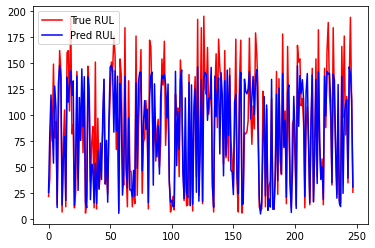

In [20]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

### Save the model weights

In [21]:
cwd = Path.cwd()
path = str(Path(cwd).parents[1]/"saved_models/cmapss/LSTM_FD004/")  + f"/FD004_early_rul_150_LSTM_rmse_{np.round(RMSE, 4)}"
model.save_weights(path)

### How to reproduce our results?
It is very likely that after running this notebook, readers may get slightly different (occasionally very differnt) results than what we have obtained here. This happens because many deep learning operations are inherently non-deterministic in nature. However, exact reproducibility can be achieved if weights of the trained model are shared. To allow readers to reproduce our results, we have shared the trained model weights [here](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/saved_models/cmapss). Steps to use shared model weights is given in [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/notebooks/cmapss_notebooks/Reproduce_results_of_FD004_early_rul_150_LSTM.ipynb). By running [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/notebooks/cmapss_notebooks/Reproduce_results_of_FD004_early_rul_150_LSTM.ipynb), results will get the exact same results that we have obtained.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open). 